In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

In [11]:
X_train = pd.read_csv('../data/train_data.csv')
y_train = pd.read_csv('../data/train_targets.csv')
df = X_train.merge(y_train, on='id')
df.head()

id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572      6000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
4  19728         0.0    2011-07-13   Action In A           0       Artisan   

   longitude   latitude              wpt_name  num_private  ... water_quality  \
0  34.938093  -9.856322                  none            0  ...          soft   
1  34.698766  -2.147466              Zahanati            0  ...          soft   
2  37.460664  -3.821329           Kwa Mahundi            0  ...          soft   
3  38.486161 -11.155298  Zahanati Ya Nanyumbu            0  ...          soft   
4  31.130847  -1.825359               Shuleni            0  ...          soft   

  quality_group      quantity  quantity_group                source  \
0          good        enough          enough                spring   
1          good  insufficient    insufficient  rainwater harvesting   
2          good        enough          enough                   dam   
3          good           dry             dry           machine dbh   
4          good      seasonal        seasonal  rainwater harvesting   

            source_type source_class              waterpoint_type  \
0                spring  groundwater           communal standpipe   
1  rainwater harvesting      surface           communal standpipe   
2                   dam      surface  communal standpipe multiple   
3              borehole  groundwater  communal standpipe multiple   
4  rainwater harvesting      surface           communal standpipe   

  waterpoint_type_group    status_group  
0    communal standpipe      functional  
1    communal standpipe      functional  
2    communal standpipe      functional  
3    communal standpipe  non functional  
4    communal standpipe      functional  

[5 rows x 41 columns]

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

# Difference between scheme management and management
We have many columns that have similar names and may contain similar values. Here we compare the scheme_management and management columns to see what kind of information we have in each.

### Cleaning
From the dataframe info above we can see that scheme_management has 55523 non-null entries out of 59400, so it has 3877 missing values. We don't know why these are recorded as null values instead of 'unkown' but it may indicate a difference in data collection method by different parties.

In [15]:
df.scheme_management.value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [16]:
df.management.value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

It looks like they have very similar value counts but we have no way to know if these line up. We'll lowercase all values in the scheme_management column and see how what percentage of values match up. In order to compare them, we first have to replace all null values in the scheme_management column.

In [20]:
df['scheme_management'].fillna('unknown', inplace=True)

In [23]:
df['scheme_management'] = df['scheme_management'].map(lambda x: x.lower())
matches = len(df[df['scheme_management'] == df['management']])/len(df)
matches*100

83.84511784511784

About 84% of our entries match up. Without any way to know which column is more trustworthy, let's look only at the entries where these values are confirmed by both columns.

In [24]:
confirmed_df = df[df['scheme_management'] == df['management']]

Let's see what the functionality rates are for waterpoints managed by different groups. We'll start with Village Water Committees because it is the largest group, and we will compare it to all management groups collectively.

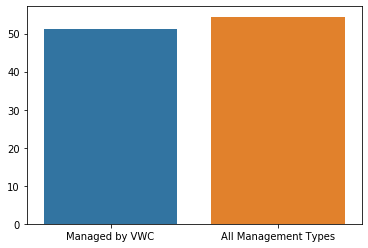

In [27]:
vwc = confirmed_df[confirmed_df['management']=='vwc']
vwc_functional = vwc[vwc['status_group']=='functional']
percent_funct_vwc = (len(vwc_functional)/len(vwc))*100

funct_all = confirmed_df[confirmed_df['status_group']=='functional']
percent_funct_all = (len(funct_all)/len(confirmed_df))*100

sns.barplot(x=['Managed by VWC', 'All Management Types'], y=[percent_funct_vwc, percent_funct_all])

The rates are similar in each one, there is likely little predictive power in this feature alone.

Let's look at all other groups

In [34]:
len(management_types)

11

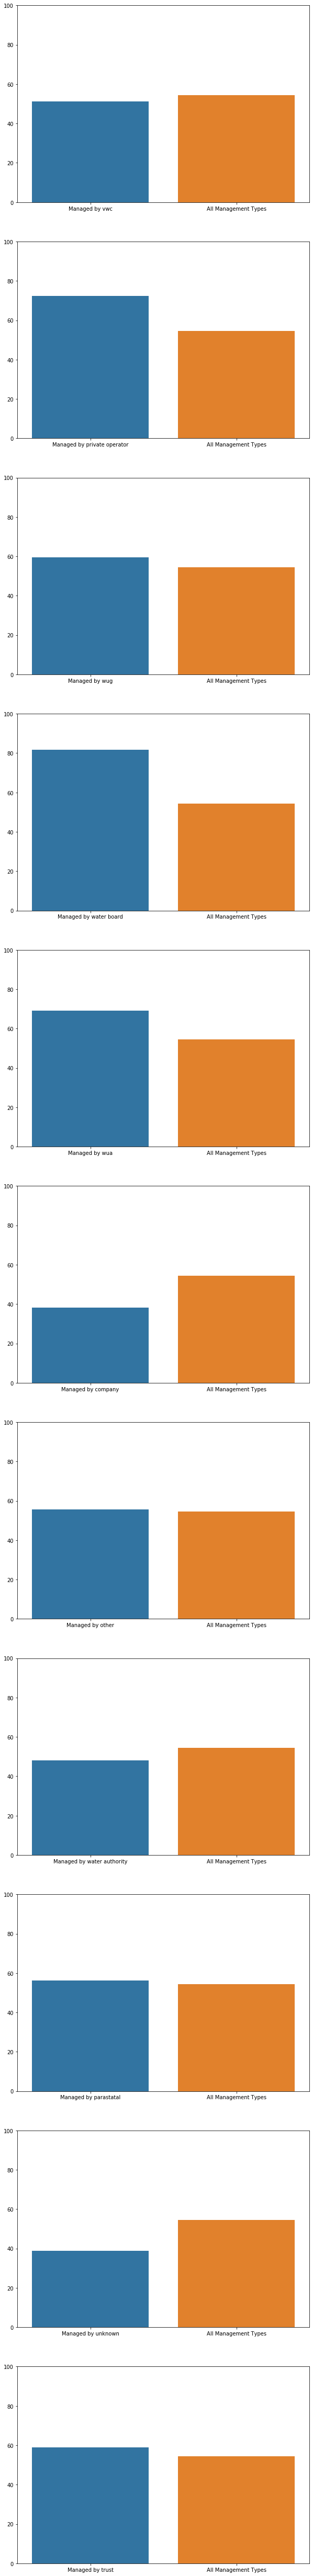

In [37]:
fig, ax = plt.subplots(11,1,figsize=(10,90))
management_types = list(confirmed_df.management.unique())
for index in range(len(management_types)):
    group_df = confirmed_df[confirmed_df['management']==management_types[index]]
    group_funct = group_df[group_df['status_group']=='functional']
    percent_funct_group = (len(group_funct)/len(group_df))*100
    ax[index].set_ylim(0,100)
    sns.barplot(x=[f'Managed by {management_types[index]}', 'All Management Types'], y=[percent_funct_group, percent_funct_all], ax = ax[index])

### Percent of values with mismatched management names

### scheme_managment
comparison of representations

In [7]:
categories = {'other - school': 'other',
             'company': 'private operator',
             'unknown': 'other',
             'trust': 'other',
             'water authority': 'other'
             }

df['management'] = df['management'].replace(categories)
df['management'].value_counts()

vwc                 40507
wug                  6515
water board          2933
private operator     2656
wua                  2535
other                2486
parastatal           1768
Name: management, dtype: int64

### Filling unkowns and others with other column

In [8]:
def fill_unknown(row):
    if (row['management'] in ['other', 'unknown']) &\
       (row['scheme_management'] in ['other', 'unknown']):
        return row
    elif row['management'] in ['other', 'unknown']:
        row['management'] = row['scheme_management']
    elif row['scheme_management'] in ['other', 'unknown']:
        row['scheme_management'] = row['management']
    return row

In [39]:
filled = df.apply(lambda row: fill_unknown(row), axis=1)

#### Column changes between rows

In [40]:
filled.management.value_counts() - df.management.value_counts()

company                NaN
other              -1282.0
parastatal             5.0
private operator      10.0
swc                    NaN
trust                  NaN
vwc                  147.0
water authority        NaN
water board           25.0
wua                    3.0
wug                   19.0
Name: management, dtype: float64

In [41]:
filled.scheme_management.value_counts() - df.scheme_management.value_counts()

company                0
none                   0
other               -219
parastatal            12
private operator     184
swc                    0
trust                  0
unknown            -3220
vwc                 2491
water authority        0
water board            0
wua                    6
wug                  746
Name: scheme_management, dtype: int64

In [42]:
filled.scheme_management.value_counts()

vwc                 39284
wug                  5952
water authority      3153
wua                  2889
water board          2748
parastatal           1692
private operator     1247
company              1061
unknown               657
other                 547
swc                    97
trust                  72
none                    1
Name: scheme_management, dtype: int64

In [43]:
filled.management.value_counts()

vwc                 40654
wug                  6534
water board          2958
private operator     2666
wua                  2538
parastatal           1773
other                1204
water authority       922
swc                    87
trust                  62
company                 2
Name: management, dtype: int64

## Conflicts between rows

In [44]:
mismatched = filled[filled['management'] != filled['scheme_management']]
mismatched

id  amount_tsh date_recorded                  funder  gps_height  \
4      19728         0.0    2011-07-13             Action In A           0   
23     37862       500.0    2013-11-03                     Isf         672   
28     19685         0.0    2013-03-05  Government Of Tanzania        1443   
31      6696        50.0    2011-03-16      Private Individual         180   
67     22108         0.0    2011-07-31  Government Of Tanzania           0   
...      ...         ...           ...                     ...         ...   
59370  14796       200.0    2013-01-29                     NaN        1154   
59377  43986         0.0    2012-10-23  Government Of Tanzania           0   
59378  38067       500.0    2011-03-21                      Rc        2101   
59391  44885         0.0    2013-08-03  Government Of Tanzania         540   
59393  48348         0.0    2012-10-27                 Private           0   

              installer  longitude  latitude          wpt_name  num_private  \
4               Artisan  31.130847 -1.825359           Shuleni            0   
23                  ISF  37.940029 -4.125595           Kinonga            0   
28     District council  37.611126 -3.263526      Kwa Kibakaya            0   
31                   WU  38.363555 -6.636104  Kituo Cha Maziwa            0   
67                  DWE  30.716090 -1.285780          Kwashuza            0   
...                 ...        ...       ...               ...          ...   
59370               NaN  30.058731 -4.902633    Village Office            0   
59377        Government  33.437012 -4.423594              Fpct            0   
59378              ACRA  34.620387 -9.358405    Michael Msigwa            0   
59391        Government  38.044070 -4.272218               Kwa            0   
59393           Private  33.866852 -4.287410         Kwa Peter            0   

       ... water_quality quality_group      quantity  quantity_group  \
4      ...          soft          good      seasonal        seasonal   
23     ...          soft          good        enough          enough   
28     ...          soft          good  insufficient    insufficient   
31     ...          soft          good        enough          enough   
67     ...          soft          good           dry             dry   
...    ...           ...           ...           ...             ...   
59370  ...       unknown       unknown       unknown         unknown   
59377  ...          soft          good  insufficient    insufficient   
59378  ...          soft          good        enough          enough   
59391  ...          soft          good        enough          enough   
59393  ...          soft          good  insufficient    insufficient   

                     source           source_type source_class  \
4      rainwater harvesting  rainwater harvesting      surface   
23                    river            river/lake      surface   
28                   spring                spring  groundwater   
31                    river            river/lake      surface   
67                   spring                spring  groundwater   
...                     ...                   ...          ...   
59370               unknown                 other      unknown   
59377                   dam                   dam      surface   
59378                spring                spring  groundwater   
59391                 river            river/lake      surface   
59393                   dam                   dam      surface   

                   waterpoint_type waterpoint_type_group    status_group  
4               communal standpipe    communal standpipe      functional  
23              communal standpipe    communal standpipe      functional  
28              communal standpipe    communal standpipe  non functional  
31              communal standpipe    communal standpipe      functional  
67                           other                 other  non functional  
...             

In [45]:
mismatched = filled[filled.management != filled.scheme_management]
(len(mismatched_management)/len(filled))*100

9.94949494949495

In [46]:
mismatched.management.value_counts()

vwc                 2628
private operator    1507
wug                 1001
water board          774
other                657
parastatal           188
wua                  160
Name: management, dtype: int64

In [54]:
management_groups = list(filled.management.value_counts().index)
management_groups

['vwc',
 'wug',
 'water board',
 'private operator',
 'wua',
 'parastatal',
 'other',
 'water authority',
 'swc',
 'trust',
 'company']

In [130]:
def calc_prcnt_by_status(df, status, value=None, col_name=None):
    if col_name:
        df = df[df[col_name] == value]
    total = len(df)
    num_status = len(df[df['status_group'] == status])
    
    return round(num_status/total*100, 2)

calc_prcnt_by_status(filled, 'non functional', 'vwc', 'management')

42.68

In [132]:
non_funct = [calc_prcnt_by_status(filled, col_name='management', value=management, status='non functional')
            for management
            in management_groups]
non_funct

[42.68, 30.15, 16.87, 32.15, 22.81, 30.34, 43.77, 44.58, 81.61, 32.26, 50.0]

In [134]:
funct = [calc_prcnt_by_status(filled, col_name='management', value=management, status='functional')
            for management
            in management_groups]
funct

[50.42, 59.96, 74.04, 65.64, 69.11, 57.7, 51.74, 48.7, 17.24, 59.68, 50.0]

In [133]:
repair = [calc_prcnt_by_status(filled, col_name='management', value=management, status='functional needs repair')
            for management
            in management_groups]
repair

[6.9, 9.89, 9.09, 2.21, 8.08, 11.96, 4.49, 6.72, 1.15, 8.06, 0.0]

In [111]:
total = len(filled)
tot_funct = len(filled[filled['status_group'] == 'functional'])
tot_non_funct = len(filled[filled['status_group'] == 'non functional'])
tot_repair = len(filled[filled['status_group'] == 'functional needs repair'])

prcnt_funct = (tot_funct/total)*100
prcnt_non_funct = (tot_non_funct/total)*100
prcnt_repair = (tot_repair/total)*100

In [138]:
def calc_prcnts(data, col_name = None, value=None):
    if col_name:
        data = data[data[col_name] == value]
    
    total = len(data)
    tot_funct = len(data[data['status_group'] == 'functional'])
    tot_non_funct = len(data[data['status_group'] == 'non functional'])
    tot_repair = len(data[data['status_group'] == 'functional needs repair'])

    prcnt_funct = round((tot_funct/total)*100, 2)
    prcnt_non_funct = round((tot_non_funct/total)*100, 2)
    prcnt_repair = round((tot_repair/total)*100, 2)
    
    return prcnt_funct, prcnt_repair, prcnt_non_funct

calc_prcnts(filled)

(54.31, 7.27, 38.42)

In [113]:
calc_prcnts(filled, 'management', 'vwc')

(50.4230825994982, 6.89723028484282, 42.67968711565898)

In [114]:
orig_prcnts = np.array(calc_prcnts(filled))
subset_prcnts = np.array(calc_prcnts(filled, 'management', 'vwc'))

dif = orig_prcnts-subset_prcnts
dif

array([ 3.88499821,  0.37044648, -4.25544469])

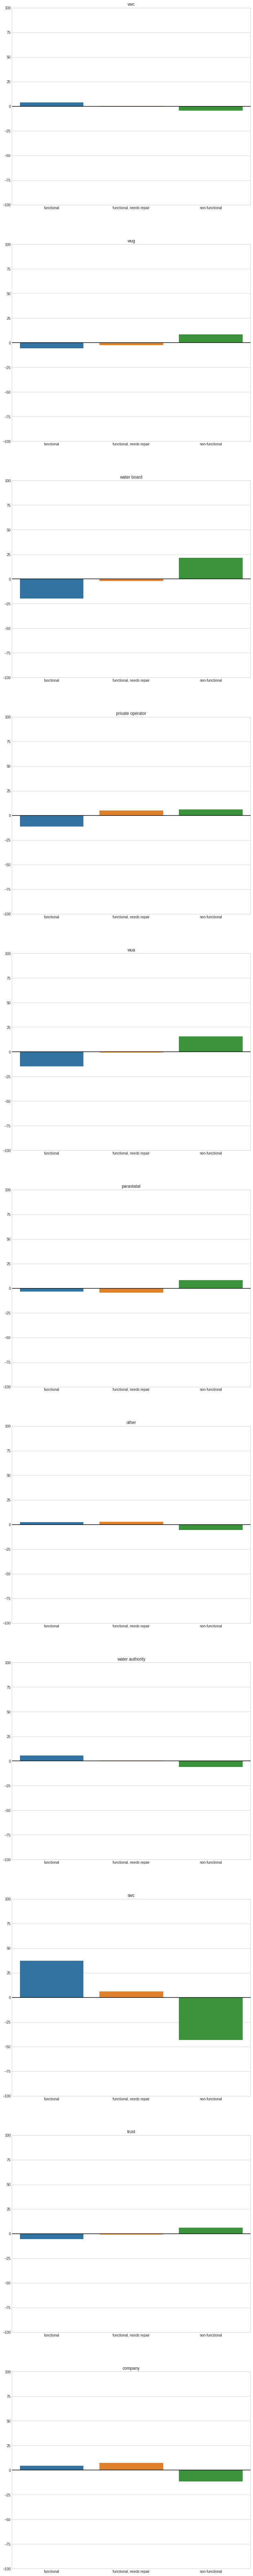

In [115]:
fig, ax = plt.subplots(len(management_groups), 1, figsize=(12,12*len(management_groups)))
orig_prcnts = np.array(calc_prcnts(filled))

for index in range(len(management_groups)):
    group = management_groups[index]
    subset_prcnts = np.array(calc_prcnts(filled, 'management', group))
    
    dif = orig_prcnts-subset_prcnts
    ax[index].set_title(group)
    
    ax[index].set_ylim(-100, 100)
    ax[index].plot([-4.5, 4.5], [0, 0], color='black')
    sns.barplot(['functional', 'functional, needs repair', 'non-functional'], dif, ax=ax[index])

In [8]:
labels = management_groups


x = np.arange(len(labels))*2  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots(1,1,figsize = (12,8))
rects1 = ax.bar(x - width*1.2, funct, width, label='functional', align='edge')
rects2 = ax.bar(x + width*1.2, repair, width, label='functional, needs repair', align='edge')
rects2 = ax.bar(x, non_funct, width, label='non-functional', align='edge')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent of Wells')
ax.set_title('Wells Binned by Management Group')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

NameError: name 'management_groups' is not defined

In [9]:

management = 'water board'

labels = ['Functional', 'Functional - Needs Repair', 'Non-functional']
data_set_prcnts = calc_prcnts(filled)
subset_percents = calc_prcnts(filled, col_name='management', value='water board')


x = np.arange(len(labels))  # the label locations
width = 0  # the width of the bars

fig, ax = plt.subplots(1,1,figsize = (12,8))
rects1 = ax.bar(x - width/2, data_set_prcnts, width, label='Total Data Set', align='edge')
rects2 = ax.bar(x + width/2, subset_percents, width, label=f'Managed by {management}', align='edge')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title(f'Rates of functionality for Water Points Managed by {management}\nvs the Whole Data Set')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(0,100)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

NameError: name 'calc_prcnts' is not defined

In [160]:
matplotlib.rcParams.update({'font.size': 22})

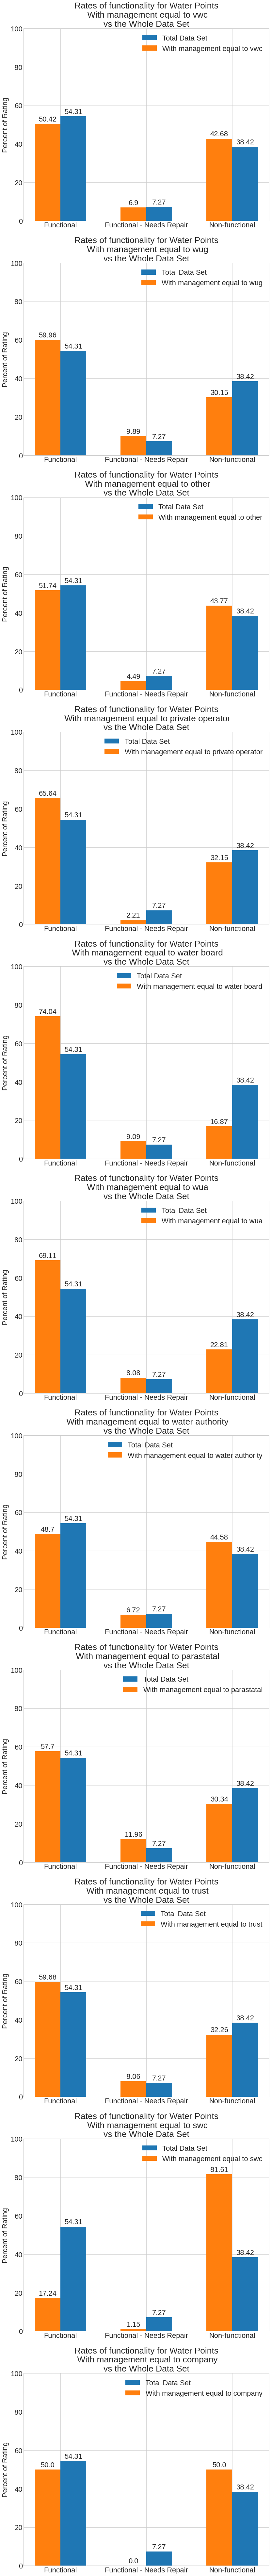

In [181]:
def analyze_by_categorical(dataframe, col_name):
    
    possible_values = list(dataframe[col_name].unique())
    column = col_name

    fig, ax = plt.subplots(len(possible_values), 1, figsize=(12,10*len(possible_values)))

    for index in range(len(possible_values)):
        value = possible_values[index]
        labels = ['Functional', 'Functional - Needs Repair', 'Non-functional']
        data_set_prcnts = calc_prcnts(dataframe)
        subset_percents = calc_prcnts(dataframe, col_name=column, value=value)

        x = np.arange(len(labels))  # the label locations
        width = 0.3  # the width of the bars


        rects1 = ax[index].bar(x + width/2, data_set_prcnts, width, label='Total Data Set', align='center')
        rects2 = ax[index].bar(x - width/2, subset_percents, width, label=f'With {col_name} equal to {value}', align='center')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax[index].set_ylabel('Percent of Rating')
        ax[index].set_title(f'Rates of functionality for Water Points\n With {col_name} equal to {value}\nvs the Whole Data Set')
        ax[index].set_xticks(x)
        ax[index].set_xticklabels(labels)
        ax[index].legend()
        ax[index].set_ylim(0,100)

        def autolabel(rects):
            """Attach a text label above each bar in *rects*, displaying its height."""
            for rect in rects:
                height = rect.get_height()
                ax[index].annotate('{}'.format(height),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')


        autolabel(rects1)
        autolabel(rects2)


    fig.tight_layout()

    plt.show()
    
analyze_by_categorical(filled, 'management')

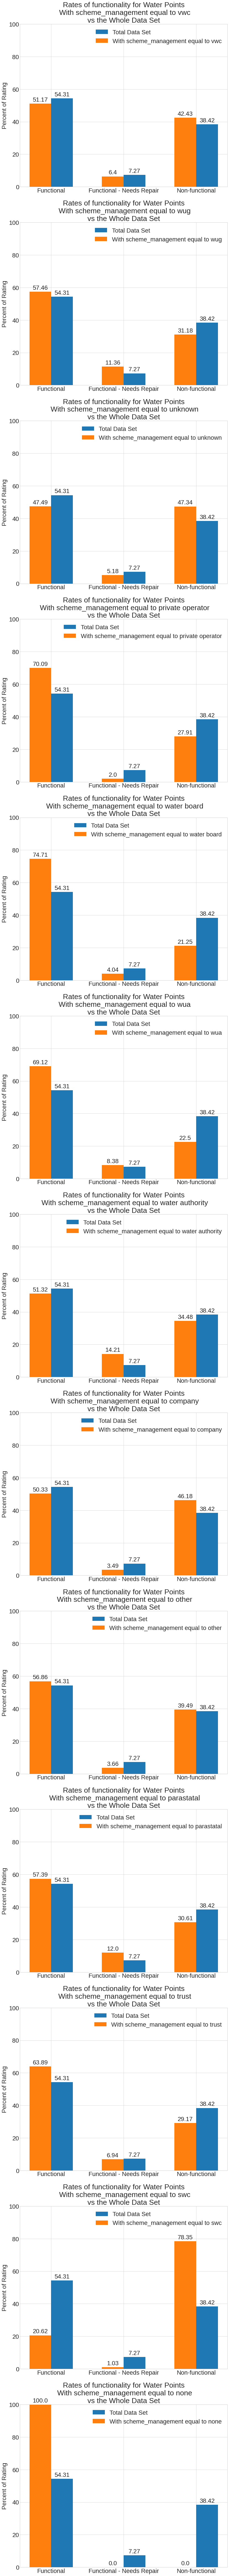

In [182]:
analyze_by_categorical(filled, 'scheme_management')

In [183]:
for col in filled.columns:
    print(f'{col}: {len(filled[col].unique())}')

id: 59400
amount_tsh: 98
date_recorded: 356
funder: 1898
gps_height: 2428
installer: 2146
longitude: 57516
latitude: 57517
wpt_name: 37400
num_private: 65
basin: 9
subvillage: 19288
region: 21
region_code: 27
district_code: 20
lga: 125
ward: 2092
population: 1049
public_meeting: 3
recorded_by: 1
scheme_management: 13
scheme_name: 2697
permit: 3
construction_year: 55
extraction_type: 18
extraction_type_group: 13
extraction_type_class: 7
management: 11
management_group: 5
payment: 7
payment_type: 7
water_quality: 8
quality_group: 6
quantity: 5
quantity_group: 5
source: 10
source_type: 7
source_class: 3
waterpoint_type: 7
waterpoint_type_group: 6
status_group: 3


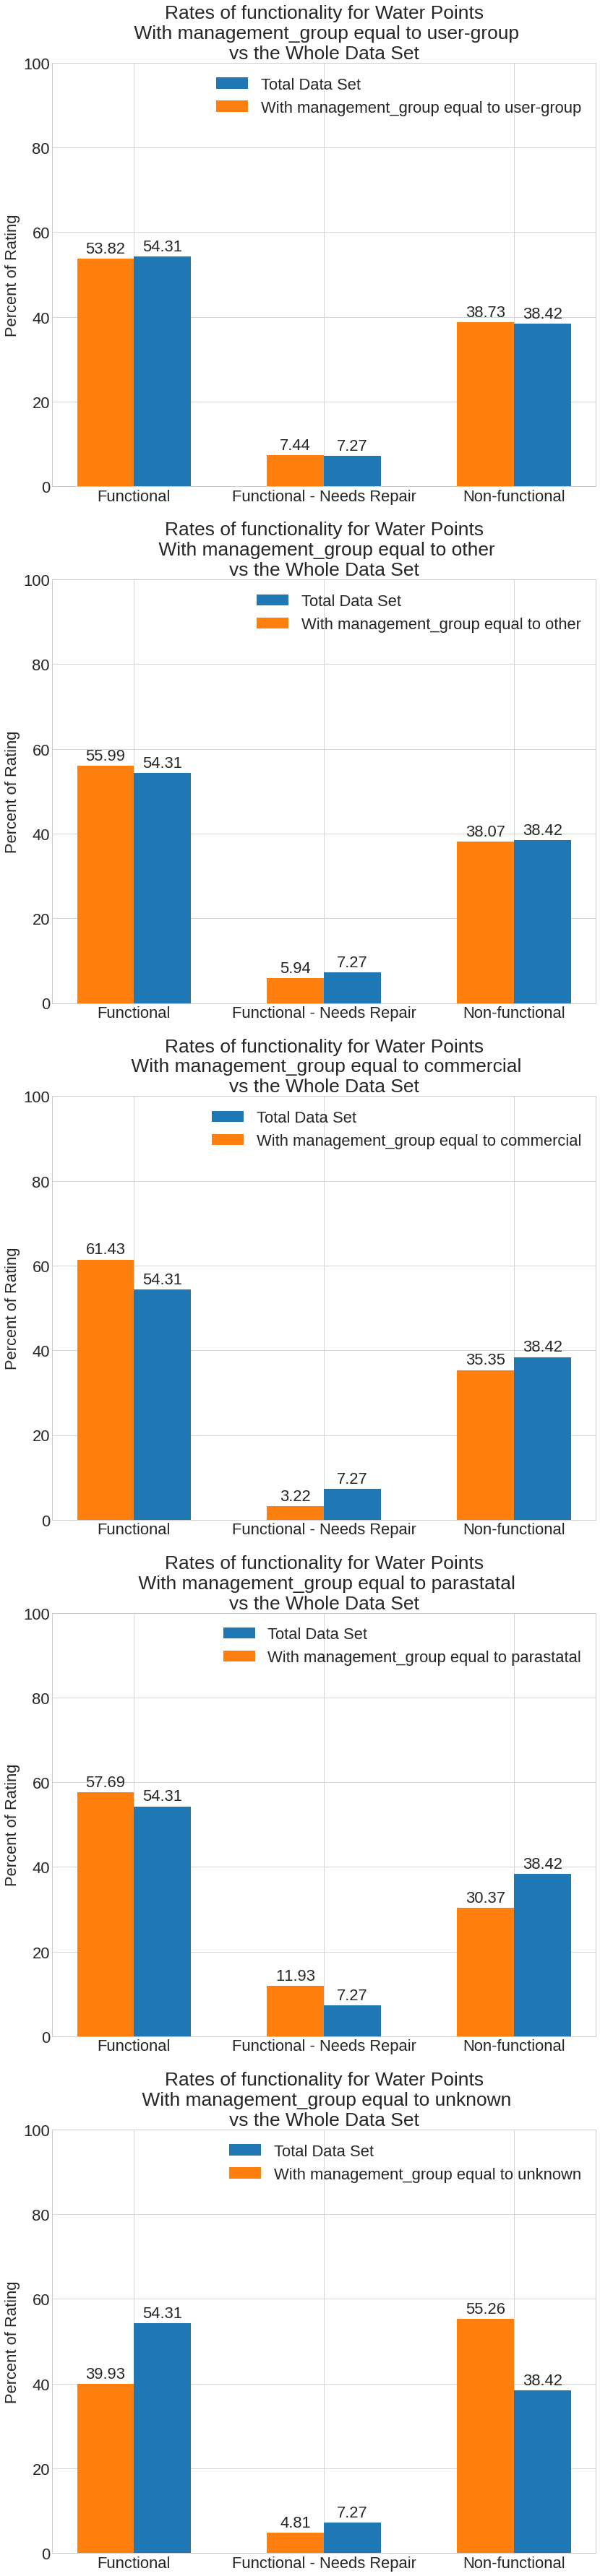

In [185]:
analyze_by_categorical(filled, 'management_group')

In [187]:
filled.public_meeting.value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

In [189]:
filled['pub_meeting_string'] = filled.public_meeting.map(str)

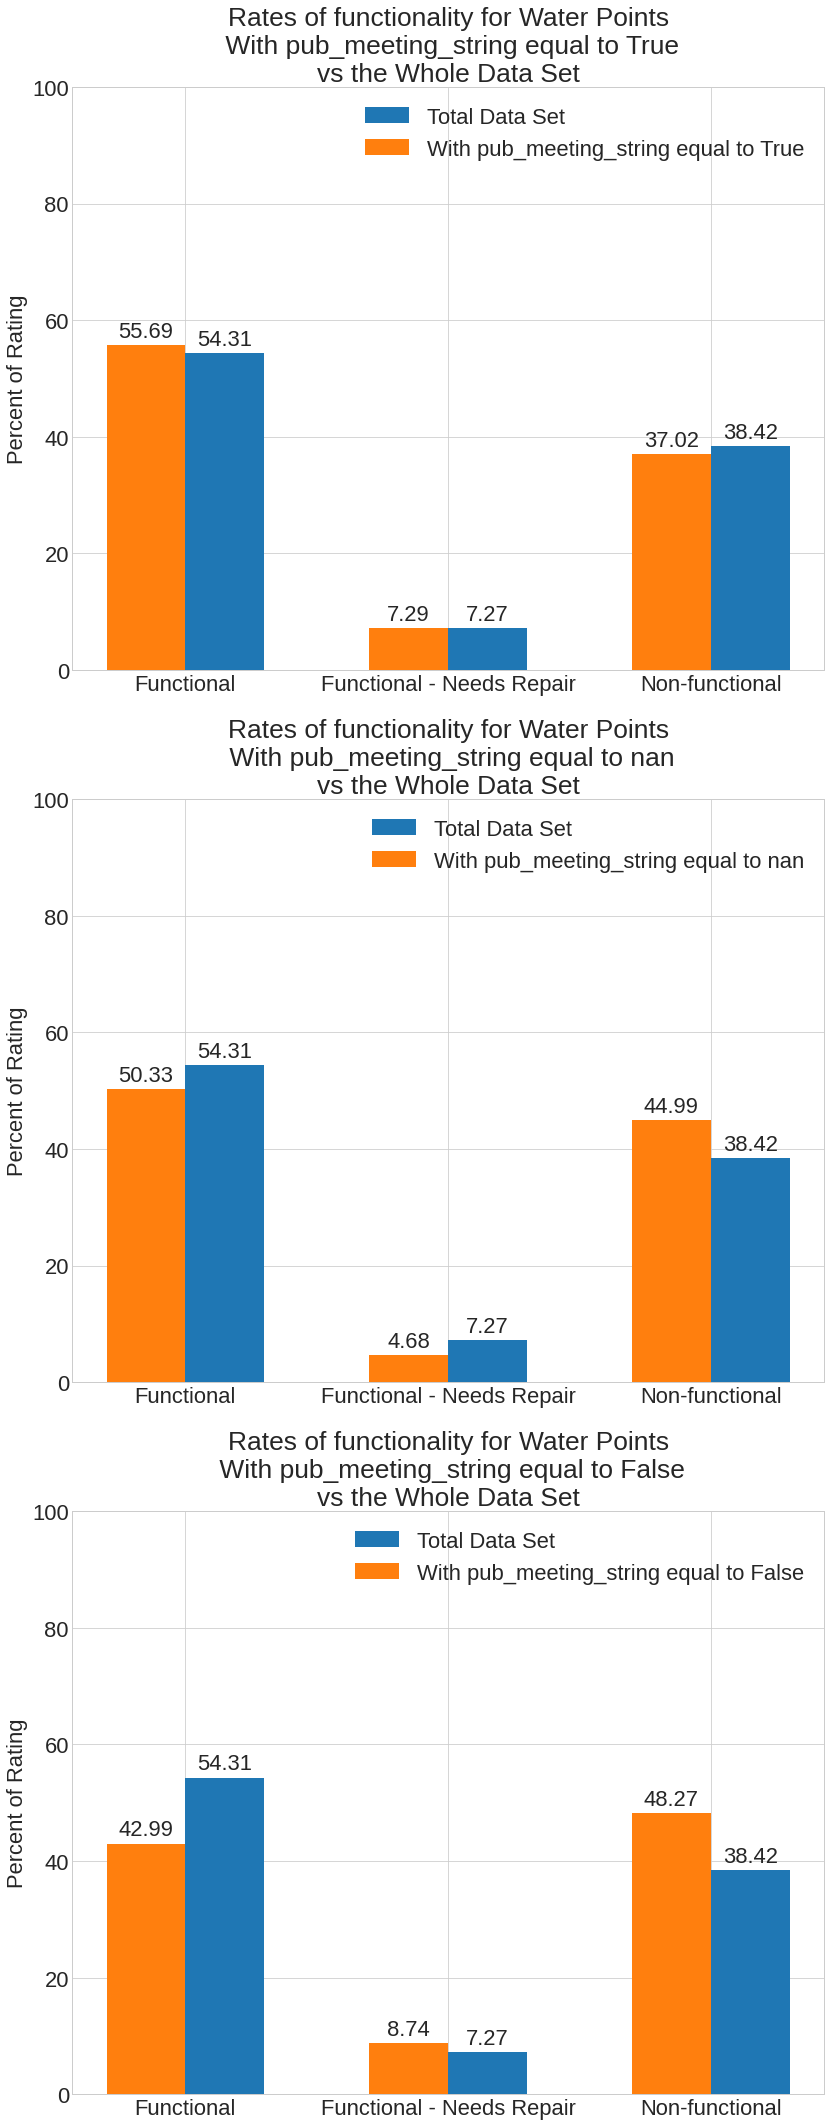

In [203]:
analyze_by_categorical(filled, 'pub_meeting_string')

# installer binning

In [206]:
filled['installer'] = filled['installer'].fillna('unknown')
filled['installer'] = filled['installer'].map(lambda x: x.lower())
print(filled.installer.value_counts()[filled.installer.value_counts()>500].sum())
(dict(filled.installer.value_counts()[filled.installer.value_counts()>500]))


34788


{'dwe': 17405,
 'unknown': 3659,
 'government': 1891,
 'hesawa': 1395,
 'rwe': 1206,
 'commu': 1065,
 'danida': 1050,
 'district council': 961,
 'kkkt': 910,
 '0': 777,
 'central government': 763,
 'tcrs': 707,
 'world vision': 699,
 'danid': 624,
 'ces': 610,
 'community': 555,
 'gover': 511}

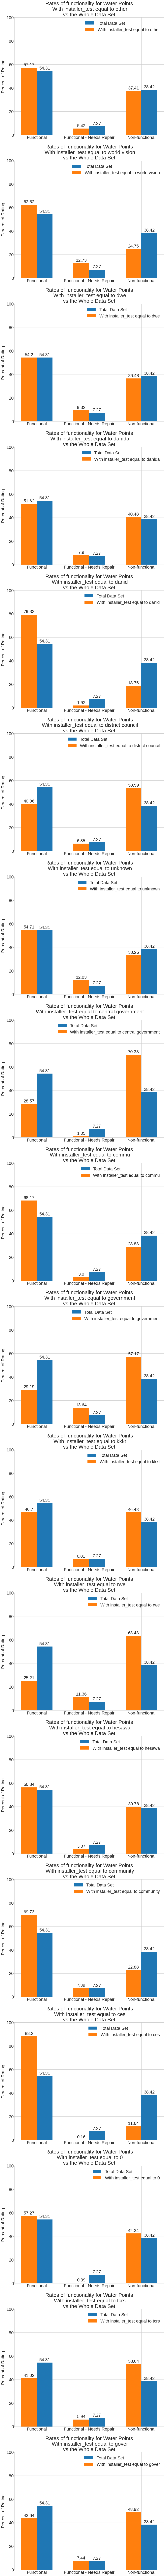

In [210]:
filled['installer_test'] = filled['installer'].map(lambda x: x if x in noteable else 'other')
noteable = list(filled.installer_test.value_counts()[filled.installer_test.value_counts()>500].index)

analyze_by_categorical(filled, 'installer_test')

In [211]:
filled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 43 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              59400 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [219]:
filled[filled['installer']=='ces'].construction_year.unique()

array([1999, 1995, 2008, 2011, 2010, 2006, 2001])